# Extract the fatigue part from the driving part
The subjects drove around 40 minutes, but we have to extract a part from it and label it as fatigue.
To do this, we extract Minute 30-35 if possible or, the last 5 minutes, from where the subject felt the most sleeping according to himself.

In [1]:
# Imports
import os, sys
import numpy as np
from typing import Tuple, List, Dict
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# to enable local imports
module_path = os.path.abspath('code')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

# variables
CWD  = os.getcwd()

kss_dict = {'Extrem wach (extremly alert)' : 1,
            'Sehr wach (very alert)' : 2,
            'Ziemlich wach (rather alert)' : 3,
            'Weder wach noch müde (neither alert nor sleepy)': 4,
            'Ein paar Anzeichen von Müdigkeit (Some signs of sleepiness)' : 5,
            'Müde, aber keine Anstrengung wach zu bleiben (sleepy, but no effort to keep awake)' : 6,
            'Müde, aber ein wenig Anstrengung wach zu bleiben (sleepy, but some effort to keep awake)' : 7,
            'Sehr Müde, große Anstrengung wach zu bleiben (Verly sleepy, great effort to keep awake, fighting sleep)' : 8,
            "Extrem müde, kann nicht wach bleiben (extremly sleepy, can't keep awake)" : 9}

kss_columns = {'Deine Probanden ID? (Your subject ID?)' : 'subject_id',
               'Wie fühlst du dich gerade? (How are you feeling right now?)' : 'kss'}


import json
from pathlib import Path

try:
    json_path = (Path(os.getenv('LOCALAPPDATA'))/'Dropbox'/'info.json').resolve()
except FileNotFoundError:
    json_path = (Path(os.getenv('APPDATA'))/'Dropbox'/'info.json').resolve()

with open(str(json_path)) as f:
    j = json.load(f)

personal_dbox_path = Path(j['personal']['path'])
# Save the images directly into the dropbox where the overleaf document is stored
IMAGES_PATH = os.path.join(str(personal_dbox_path), 'Apps', 'Overleaf', 'Masterthesis_Paper', 'images')
print("Saving images to: {}".format(IMAGES_PATH))
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

D:\Masterthesis\thesis_eeg\data_processing\code
Saving images to: D:\Dropbox\Apps\Overleaf\Masterthesis_Paper\images


In [2]:
def load_kss_csv(file_name) -> pd.DataFrame:
    print("Loadking KSS cvs with name: {}".format(file_name))
    df = pd.read_csv(os.path.join(CWD, '..', '..', 'EEG_Data', 'muse_data', file_name))
    df.replace(kss_dict, inplace=True)
    df.rename(columns=kss_columns, inplace=True)
    df.drop(['Antwort ID', 'Datum Abgeschickt', 'Letzte Seite', 'Start-Sprache', 'Zufallswert'], axis=1, inplace=True)
    return df
    
def load_subject_data(subject_id):
    #print("Loading data from subject : {}".format(subject_id))
    subject_dir = os.path.join(CWD, '..', '..', 'EEG_Data', 'muse_data', 'subject_{}'.format(subject_id))
    if not os.path.isdir(subject_dir):
        raise Exception("The dir is not there: {}".format(subject_dir))
    
    
    df = pd.read_csv(os.path.join(subject_dir, 'driving_complete.csv'))
    
    df['Time:256Hz'] = pd.to_datetime(df['Time:256Hz'])
    # set new index and delete the Time:256Hz column
    df.set_index(df['Time:256Hz'], inplace=True)
    del df['Time:256Hz']
    
    return df
    
def save_muse_df_to_csv(df, subject_id, file_ending):
    ''' Save the given df as a .csv into the subject directory'''
    file_name = '{ending}.csv'.format(ending=file_ending) # just use a simple name without date. Easier for later. The date is already in the index
    subject_dir = os.path.join(CWD, '..', '..', 'EEG_Data', 'muse_data', 'subject_{}'.format(subject_id))
    file_path = os.path.join(subject_dir, file_name)
    df.to_csv(file_path, encoding='utf-8')
    
    print("Saved {} to: {}".format(file_ending, file_path))
    
# Extract EEG Data from Subject
def extract_data_from_driving(subject_id, kss, timedelta_start, timedelta_duration, label='fatigue'):
    ''' Extract data from the driving part by a given duration'''

    df = load_subject_data(subject_id)

    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    
    # eeg data
    ax[0].set_title("Subject {} - EEG Data".format(subject_id))
    ax[0].plot(df['TP9'], label='TP9', color='black')
    ax[0].plot(df['AF7'], label='TP7', color='black')
    ax[0].plot(df['AF8'], label='TP8', color='black')
    ax[0].plot(df['TP10'], label='TP10', color='black')
    ax[0].set_ylabel("Raw EEG Value / Amplitude")
    ax[0].set_xlabel("Sample")
    # start marker
    ax[0].axvline(x=df.index[0]+timedelta_start, color='red')
    # end marker
    ax[0].axvline(x=df.index[0]+timedelta_start+timedelta_duration, color='red')
    
    # kss data 
    subject_kss = kss[kss.subject_id == subject_id]
    ax[1].set_title("Subject {} - KSS Data".format(subject_id))
    y = subject_kss.kss
    x = list(range(1, len(y)+1))
    ax[1].plot(x, y, label='KSS')
    ax[1].set_xticks(x)
    ax[1].set_ylim(0,10)
    ax[1].set_ylabel("KSS Scale")
    ax[1].set_xlabel("KSS question count")
    
    
    save_fig("exp_data_fatigue_extraction_subject_{}".format(subject_id))
    
    # slice the df, where the markers are
    idx = pd.IndexSlice
    df_sliced = df[idx[ df.index[0]+timedelta_start : df.index[0]+timedelta_start+timedelta_duration]]
    return df_sliced

kss = load_kss_csv('kss_survey_results.csv')

Loadking KSS cvs with name: kss_survey_results.csv


In [5]:
kss.kss.max()

9.0

## Extract fatigue data from subject 2

Saving figure exp_data_fatigue_extraction_subject_2
Saved driving_fatigue to: D:\Masterthesis\thesis_eeg\data_processing\..\..\EEG_Data\muse_data\subject_2\driving_fatigue.csv


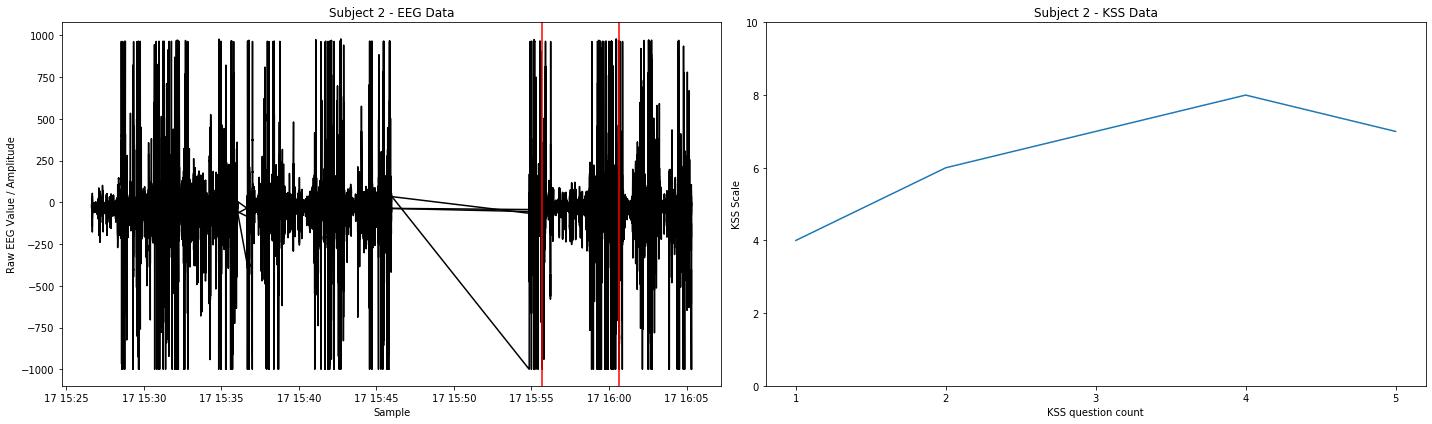

In [4]:
subject_id = 2
minute_offset = 29
minute_duration = 5
df_sliced = extract_data_from_driving(subject_id=subject_id, kss=kss, timedelta_start=timedelta(minutes=minute_offset), timedelta_duration=timedelta(minutes=minute_duration))

save_muse_df_to_csv(df=df_sliced, subject_id=subject_id, file_ending='driving_fatigue')

## Extract fatigue data from subject 3

Saving figure exp_data_fatigue_extraction_subject_3
Saved driving_fatigue to: D:\Masterthesis\thesis_eeg\data_processing\..\..\EEG_Data\muse_data\subject_3\driving_fatigue.csv


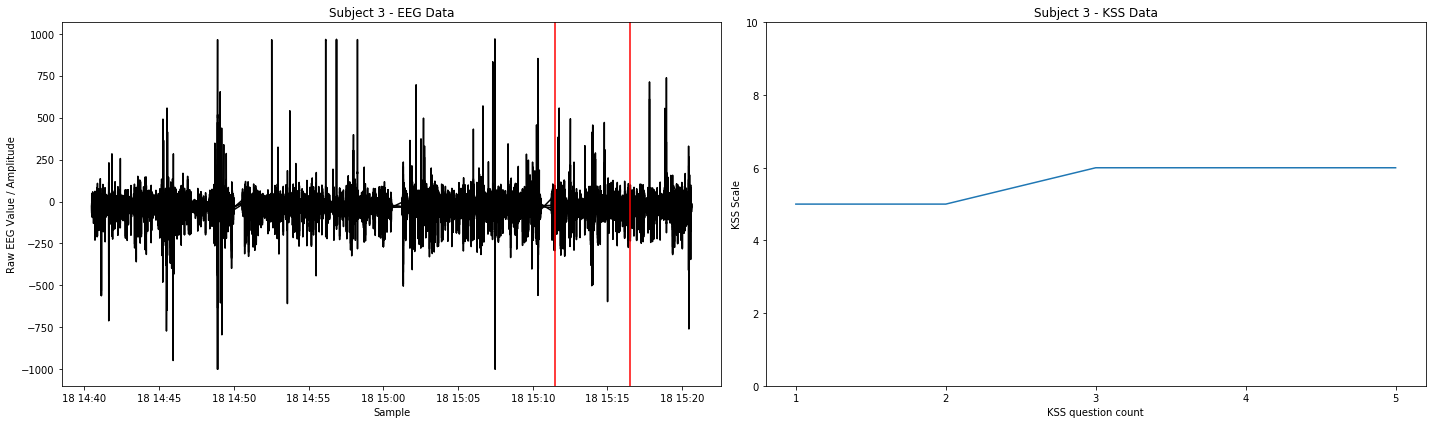

In [36]:
subject_id = 3
minute_offset = 31
minute_duration = 5
df_sliced = extract_data_from_driving(subject_id=subject_id, kss=kss, timedelta_start=timedelta(minutes=minute_offset), timedelta_duration=timedelta(minutes=minute_duration))

save_muse_df_to_csv(df=df_sliced, subject_id=subject_id, file_ending='driving_fatigue')

## Extract fatigue data from subject 4

Saving figure exp_data_fatigue_extraction_subject_4
Saved driving_fatigue to: D:\Masterthesis\thesis_eeg\data_processing\..\..\EEG_Data\muse_data\subject_4\driving_fatigue.csv


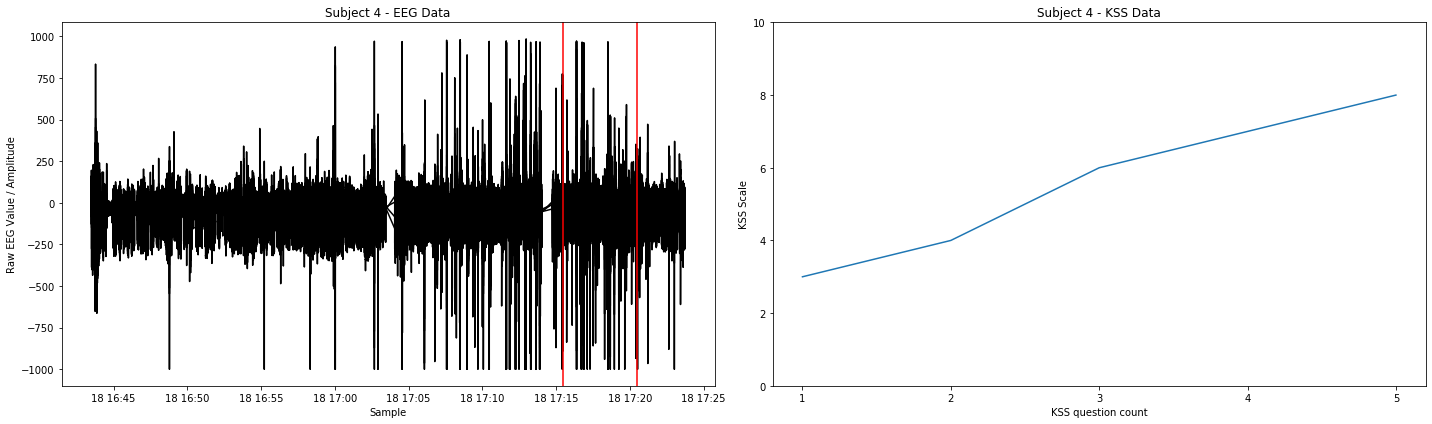

In [37]:
subject_id = 4
minute_offset = 32
minute_duration = 5
df_sliced = extract_data_from_driving(subject_id=subject_id, kss=kss, timedelta_start=timedelta(minutes=minute_offset), timedelta_duration=timedelta(minutes=minute_duration))

save_muse_df_to_csv(df=df_sliced, subject_id=subject_id, file_ending='driving_fatigue')

## Extract fatigue data from subject 5

Saving figure exp_data_fatigue_extraction_subject_5
Saved driving_fatigue to: D:\Masterthesis\thesis_eeg\data_processing\..\..\EEG_Data\muse_data\subject_5\driving_fatigue.csv


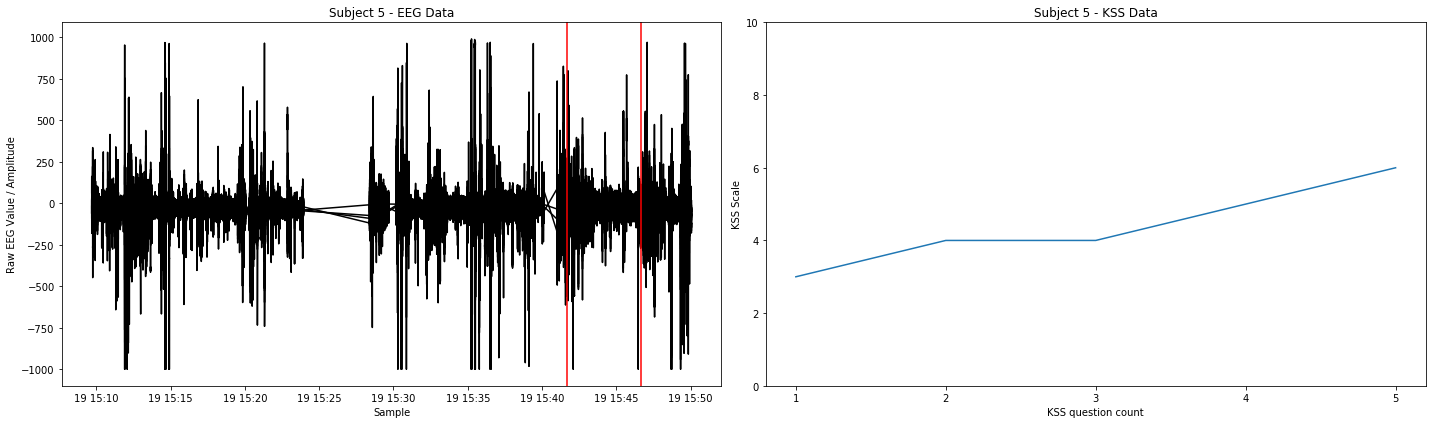

In [38]:
subject_id = 5
minute_offset = 32
minute_duration = 5
df_sliced = extract_data_from_driving(subject_id=subject_id, kss=kss, timedelta_start=timedelta(minutes=minute_offset), timedelta_duration=timedelta(minutes=minute_duration))

save_muse_df_to_csv(df=df_sliced, subject_id=subject_id, file_ending='driving_fatigue')

## Extract fatigue data from subject 6 - faulty

In [39]:
subject_id = 6
minute_offset = 29
minute_duration = 5
#df_sliced = extract_data_from_driving(subject_id=subject_id, kss=kss, timedelta_start=timedelta(minutes=minute_offset), timedelta_duration=timedelta(minutes=minute_duration))
#save_muse_df_to_csv(df=df_sliced, subject_id=subject_id, file_ending='driving_fatigue')

## Extract fatigue data from subject 7

Saving figure exp_data_fatigue_extraction_subject_7
Saved driving_fatigue to: D:\Masterthesis\thesis_eeg\data_processing\..\..\EEG_Data\muse_data\subject_7\driving_fatigue.csv


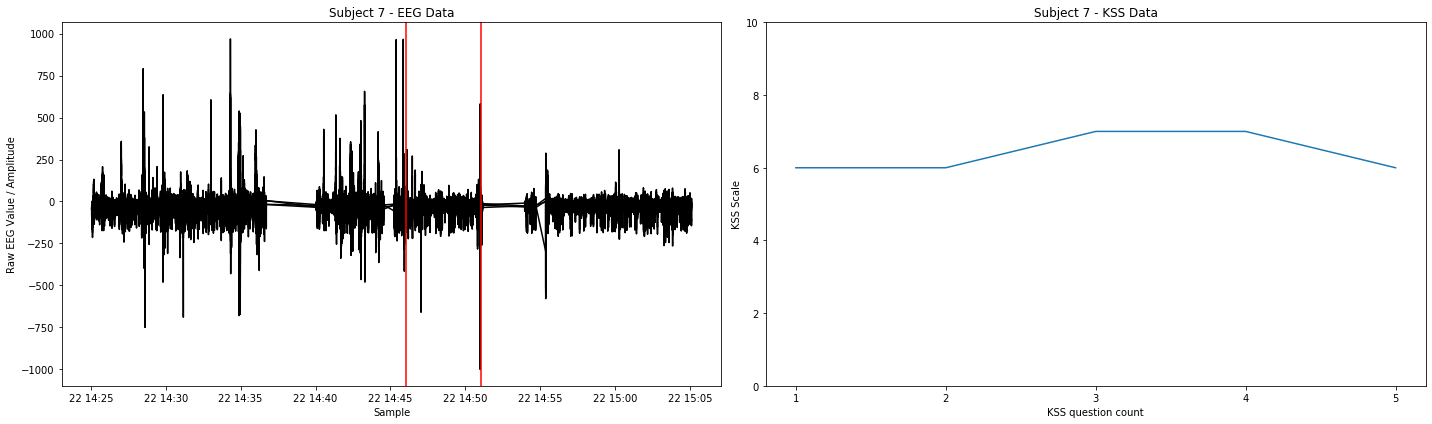

In [40]:
subject_id = 7
minute_offset = 21
minute_duration = 5
df_sliced = extract_data_from_driving(subject_id=subject_id, kss=kss, timedelta_start=timedelta(minutes=minute_offset), timedelta_duration=timedelta(minutes=minute_duration))
save_muse_df_to_csv(df=df_sliced, subject_id=subject_id, file_ending='driving_fatigue')

## Extract fatigue data from subject 8

Saving figure exp_data_fatigue_extraction_subject_8
Saved driving_fatigue to: D:\Masterthesis\thesis_eeg\data_processing\..\..\EEG_Data\muse_data\subject_8\driving_fatigue.csv


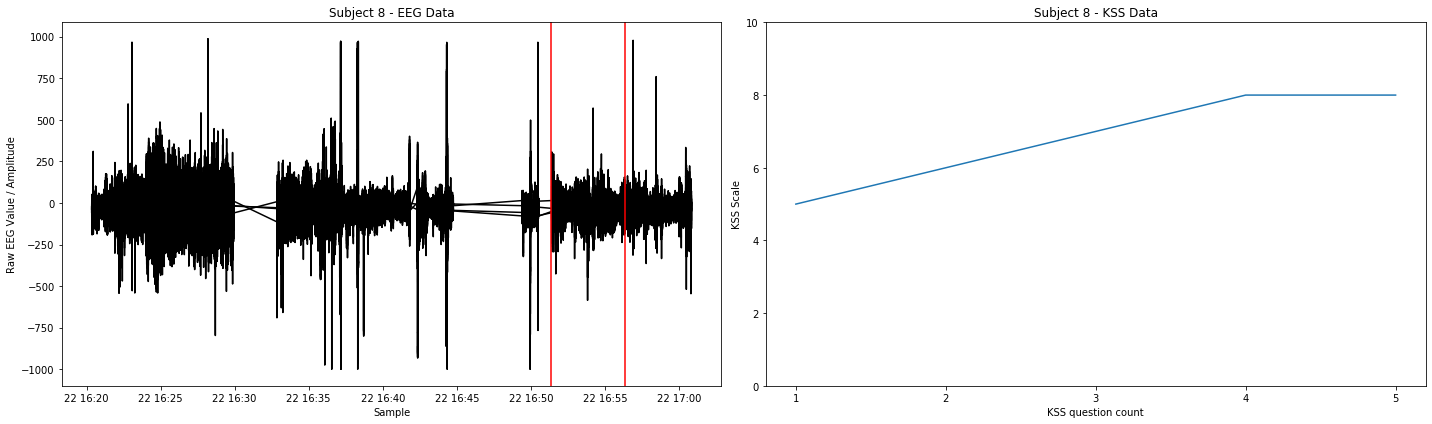

In [41]:
subject_id = 8
minute_offset = 31
minute_duration = 5
df_sliced = extract_data_from_driving(subject_id=subject_id, kss=kss, timedelta_start=timedelta(minutes=minute_offset), timedelta_duration=timedelta(minutes=minute_duration))

save_muse_df_to_csv(df=df_sliced, subject_id=subject_id, file_ending='driving_fatigue')

## Extract fatigue data from subject 9

Saving figure exp_data_fatigue_extraction_subject_9
Saved driving_fatigue to: D:\Masterthesis\thesis_eeg\data_processing\..\..\EEG_Data\muse_data\subject_9\driving_fatigue.csv


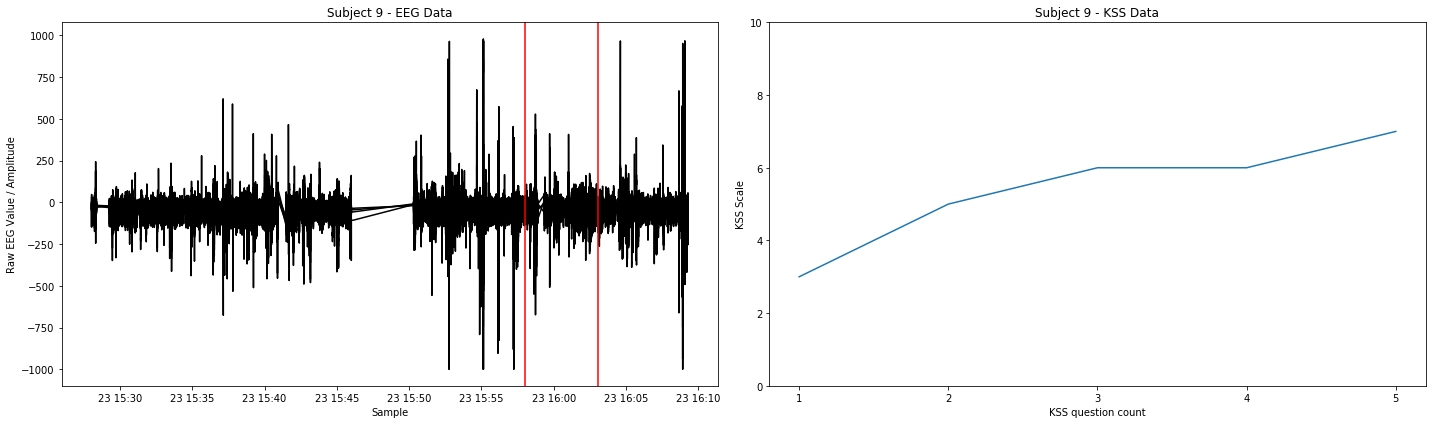

In [42]:
subject_id = 9
minute_offset = 30
minute_duration = 5
df_sliced = extract_data_from_driving(subject_id=subject_id, kss=kss, timedelta_start=timedelta(minutes=minute_offset), timedelta_duration=timedelta(minutes=minute_duration))

save_muse_df_to_csv(df=df_sliced, subject_id=subject_id, file_ending='driving_fatigue')

## Extract fatigue data from subject 10

Saving figure exp_data_fatigue_extraction_subject_10
Saved driving_fatigue to: D:\Masterthesis\thesis_eeg\data_processing\..\..\EEG_Data\muse_data\subject_10\driving_fatigue.csv


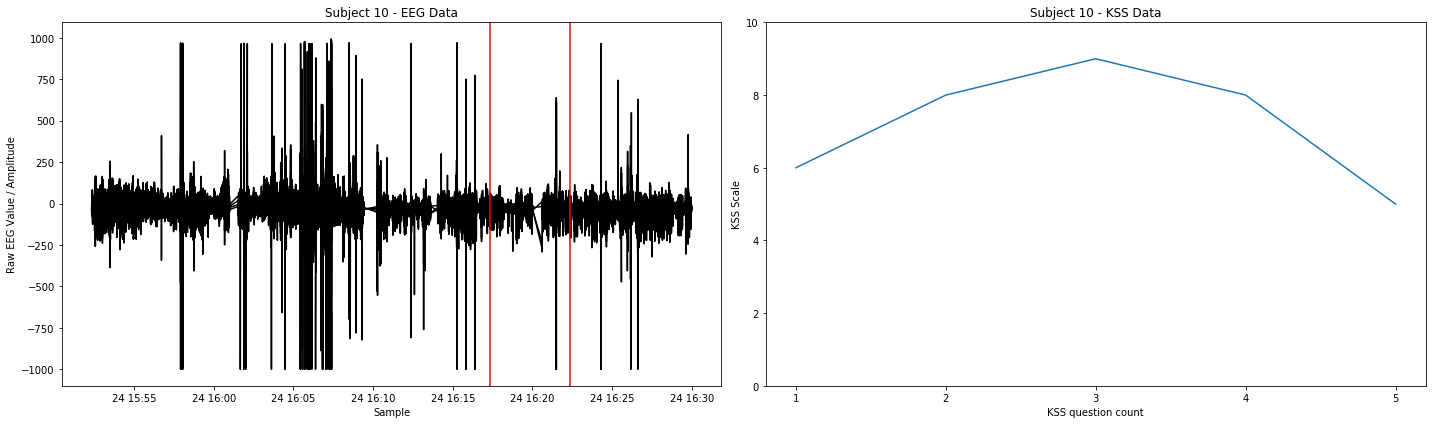

In [14]:
subject_id = 10
minute_offset = 25
minute_duration = 5
df_sliced = extract_data_from_driving(subject_id=subject_id, kss=kss, timedelta_start=timedelta(minutes=minute_offset), timedelta_duration=timedelta(minutes=minute_duration))

save_muse_df_to_csv(df=df_sliced, subject_id=subject_id, file_ending='driving_fatigue')

## Extract fatigue data from subject 11

Saving figure exp_data_fatigue_extraction_subject_11
Saved driving_fatigue to: D:\Masterthesis\thesis_eeg\data_processing\..\..\EEG_Data\muse_data\subject_11\driving_fatigue.csv


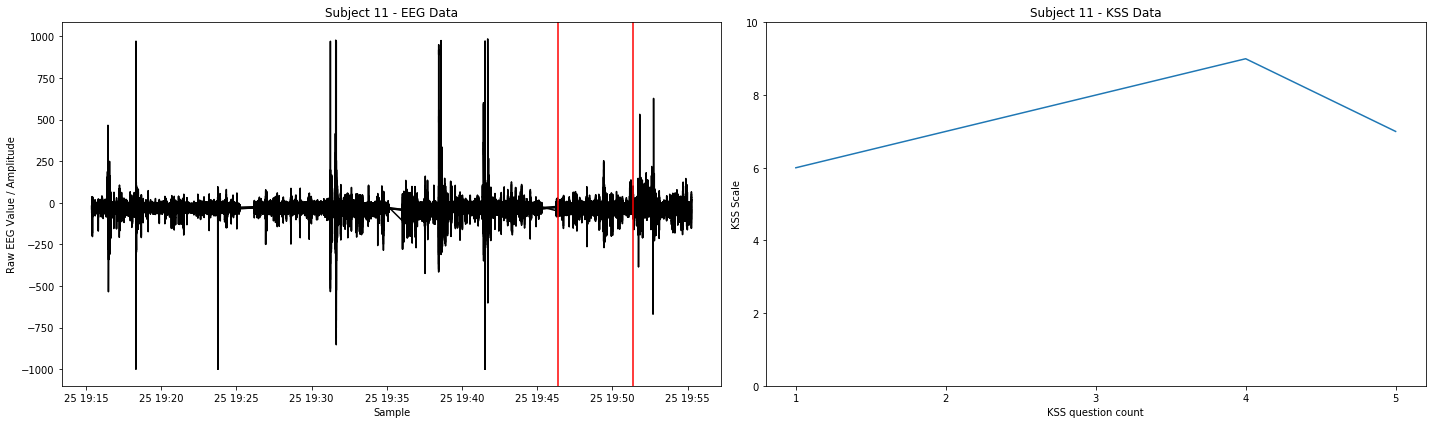

In [13]:
subject_id = 11
minute_offset = 31
minute_duration = 5
df_sliced = extract_data_from_driving(subject_id=subject_id, kss=kss, timedelta_start=timedelta(minutes=minute_offset), timedelta_duration=timedelta(minutes=minute_duration))

save_muse_df_to_csv(df=df_sliced, subject_id=subject_id, file_ending='driving_fatigue')

## Extract fatigue data from subject 12

Saving figure exp_data_fatigue_extraction_subject_12
Saved driving_fatigue to: D:\Masterthesis\thesis_eeg\data_processing\..\..\EEG_Data\muse_data\subject_12\driving_fatigue.csv


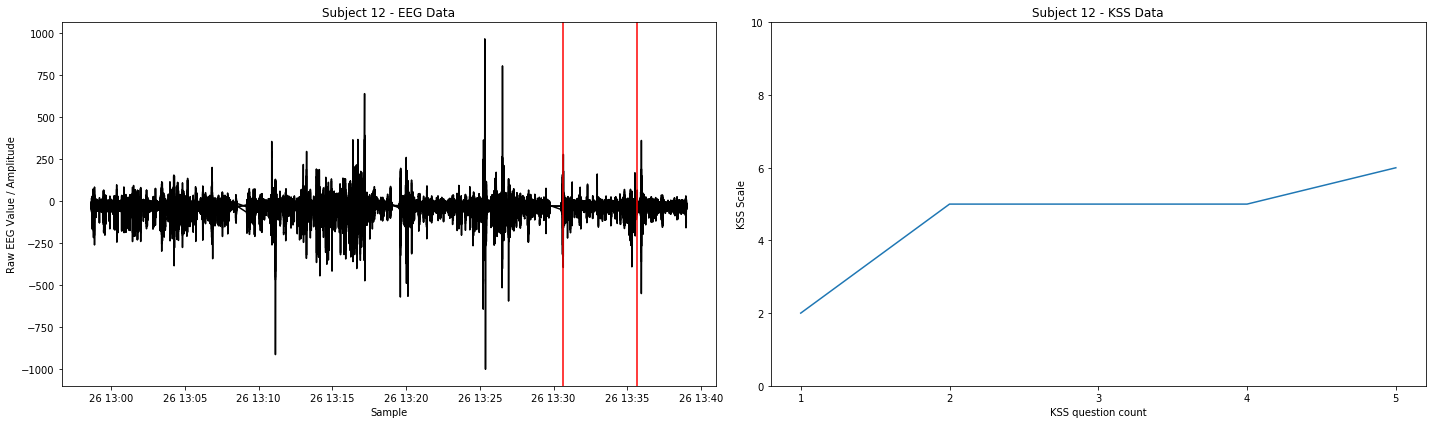

In [12]:
subject_id = 12
minute_offset = 32
minute_duration = 5
df_sliced = extract_data_from_driving(subject_id=subject_id, kss=kss, timedelta_start=timedelta(minutes=minute_offset), timedelta_duration=timedelta(minutes=minute_duration))

save_muse_df_to_csv(df=df_sliced, subject_id=subject_id, file_ending='driving_fatigue')

## Extract fatigue data from subject 13

Saving figure exp_data_fatigue_extraction_subject_13
Saved driving_fatigue to: D:\Masterthesis\thesis_eeg\data_processing\..\..\EEG_Data\muse_data\subject_13\driving_fatigue.csv


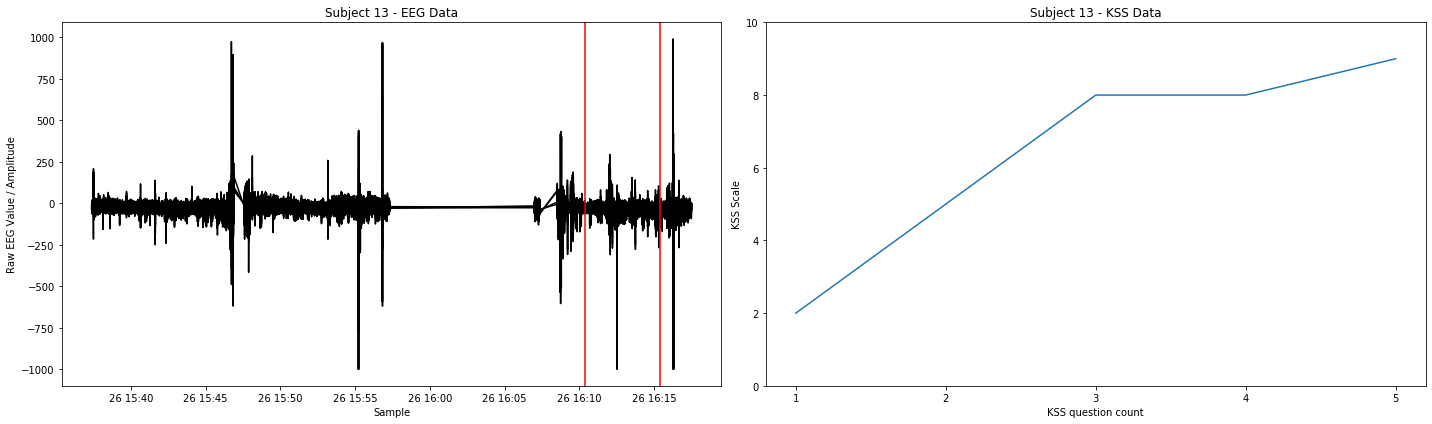

In [21]:
subject_id = 13
minute_offset = 33
minute_duration = 5
df_sliced = extract_data_from_driving(subject_id=subject_id, kss=kss, timedelta_start=timedelta(minutes=minute_offset), timedelta_duration=timedelta(minutes=minute_duration))

save_muse_df_to_csv(df=df_sliced, subject_id=subject_id, file_ending='driving_fatigue')

## Extract fatigue data from subject 14

Saving figure exp_data_fatigue_extraction_subject_14
Saved driving_fatigue to: D:\Masterthesis\thesis_eeg\data_processing\..\..\EEG_Data\muse_data\subject_14\driving_fatigue.csv


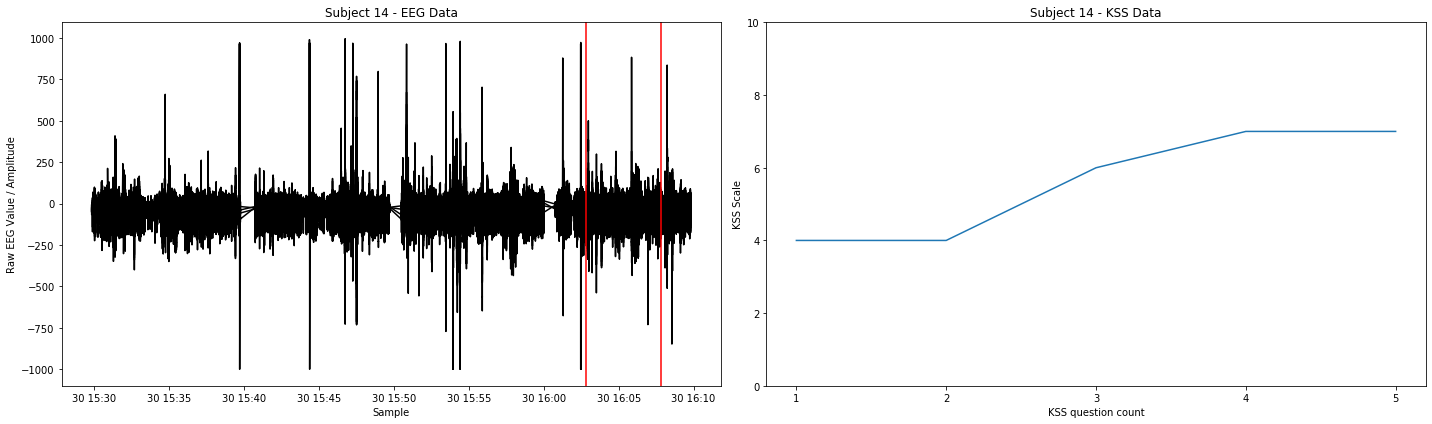

In [22]:
subject_id = 14
minute_offset = 33
minute_duration = 5
df_sliced = extract_data_from_driving(subject_id=subject_id, kss=kss, timedelta_start=timedelta(minutes=minute_offset), timedelta_duration=timedelta(minutes=minute_duration))

save_muse_df_to_csv(df=df_sliced, subject_id=subject_id, file_ending='driving_fatigue')

## Extract fatigue data from subject 15

Saving figure exp_data_fatigue_extraction_subject_15
Saved driving_fatigue to: D:\Masterthesis\thesis_eeg\data_processing\..\..\EEG_Data\muse_data\subject_15\driving_fatigue.csv


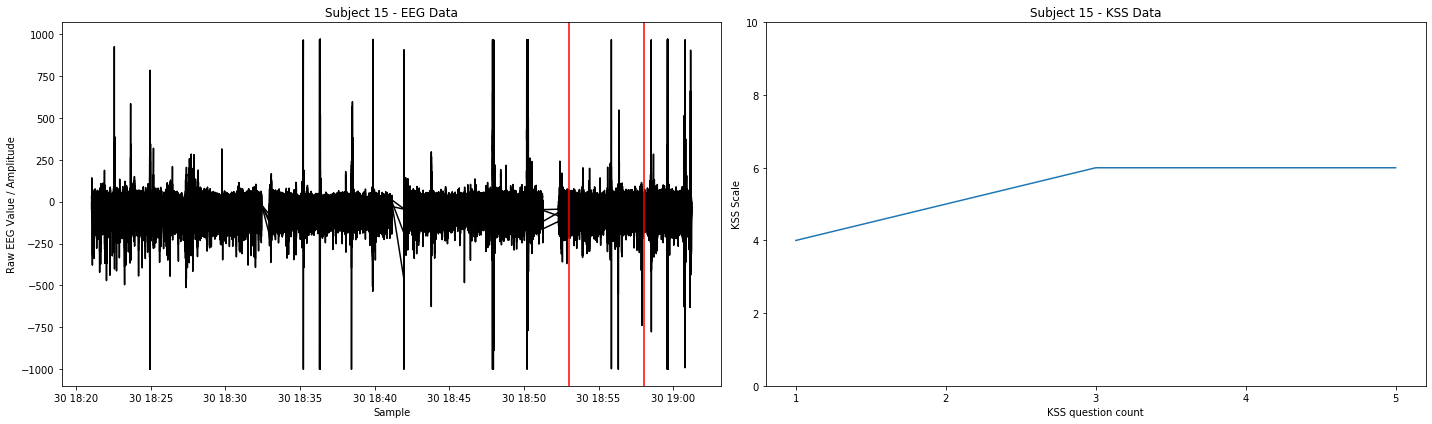

In [20]:
subject_id = 15
minute_offset = 32
minute_duration = 5
df_sliced = extract_data_from_driving(subject_id=subject_id, kss=kss, timedelta_start=timedelta(minutes=minute_offset), timedelta_duration=timedelta(minutes=minute_duration))

save_muse_df_to_csv(df=df_sliced, subject_id=subject_id, file_ending='driving_fatigue')